# Exploring the single member (mem001) control and historical runs

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# ocean_scalar

In [20]:
hist_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/ZARR/ocean_scalar_month.zarr.zip'
ctrl_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101/ZARR/ocean_scalar_month.zarr.zip'
ctrl_nvol_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101-no_volcanos//ZARR/ocean_scalar_month.zarr.zip'

hist_nvol_path = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/ocean_scalar*.nc'))
hist_nvol_path_branch_dt1200 = hist_nvol_path + sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1200/ocean_scalar*.nc'))
hist_nvol_path_branch_dt1800 = hist_nvol_path + sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1800/ocean_scalar*.nc'))
hist_nvol_path_branch_dt1800_900_1800 = hist_nvol_path + sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1800-900-1800/ocean_scalar*.nc'))

hist_nvol_path_dt1200 = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-no_volcanos-dt1200/mem001/ocean_scalar*.nc'))[:-1]

hist_nvol_path_dt900 = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-no_volcanos-dt900/mem001/ocean_scalar*.nc'))[:-1]

forcing_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-no_volcanos/mem001/'

In [21]:
hist_ocean_scalar = xr.open_zarr(hist_path, consolidated=True).squeeze()
ctrl_ocean_scalar = xr.open_zarr(ctrl_path, consolidated=True).squeeze()
ctrl_nvol_ocean_scalar = xr.open_zarr(ctrl_nvol_path, consolidated=True).squeeze()

hist_nvol_ocean_scalar_branch_dt1200 = xr.open_mfdataset(hist_nvol_path_branch_dt1200)
hist_nvol_ocean_scalar_branch_dt1800 = xr.open_mfdataset(hist_nvol_path_branch_dt1800)
hist_nvol_ocean_scalar_branch_dt1800_900_1800 = xr.open_mfdataset(hist_nvol_path_branch_dt1800_900_1800)

hist_nvol_ocean_scalar_dt1200 = xr.open_mfdataset(hist_nvol_path_dt1200)

hist_nvol_ocean_scalar_dt900 = xr.open_mfdataset(hist_nvol_path_dt900)

In [22]:
variable = 'temp_total'
variable_long_name = ctrl_nvol_ocean_scalar[variable].attrs['long_name']
variable_units = ctrl_nvol_ocean_scalar[variable].attrs['units']

clim_period = slice('1980','1999')
clim =  ctrl_nvol_ocean_scalar[variable].sel(time=clim_period).groupby('time.month').mean('time')

ctrl_ocean_scalar = ctrl_ocean_scalar[variable].groupby('time.month') - clim
ctrl_nvol_ocean_scalar = ctrl_nvol_ocean_scalar[variable].groupby('time.month') - clim
hist_ocean_scalar = hist_ocean_scalar[variable].groupby('time.month') - clim
hist_nvol_ocean_scalar_branch_dt1200 = hist_nvol_ocean_scalar_branch_dt1200[variable].groupby('time.month') - clim
hist_nvol_ocean_scalar_branch_dt1800 = hist_nvol_ocean_scalar_branch_dt1800[variable].groupby('time.month') - clim
hist_nvol_ocean_scalar_branch_dt1800_900_1800 = hist_nvol_ocean_scalar_branch_dt1800_900_1800[variable].groupby('time.month') - clim
hist_nvol_ocean_scalar_dt1200 = hist_nvol_ocean_scalar_dt1200[variable].groupby('time.month') - clim
hist_nvol_ocean_scalar_dt900 = hist_nvol_ocean_scalar_dt900[variable].groupby('time.month') - clim

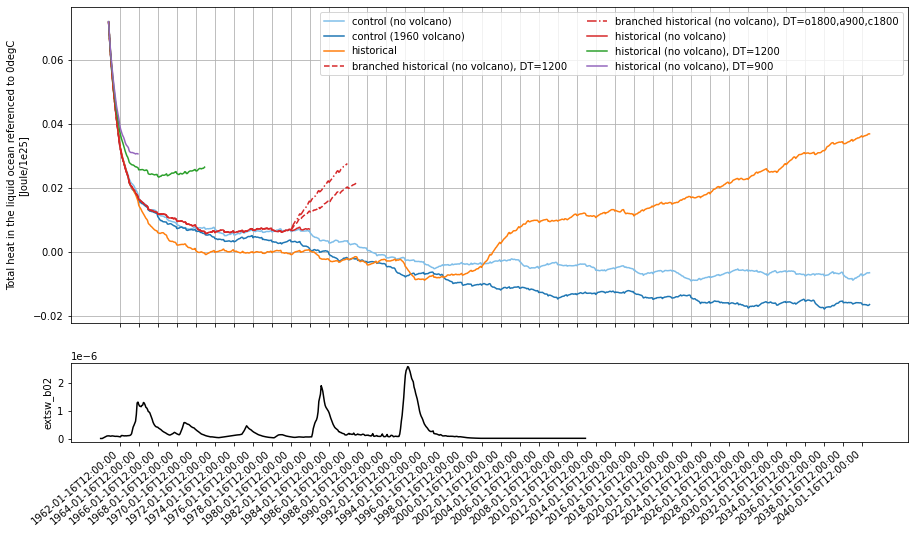

In [23]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(15,8))

def lighten(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

ax0.plot([np.datetime64(t.strftime()) for t in ctrl_nvol_ocean_scalar.time.values], 
         ctrl_nvol_ocean_scalar, 
         label='control (no volcano)', color=lighten('C0'), linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in ctrl_ocean_scalar.time.values], 
         ctrl_ocean_scalar, 
         label='control (1960 volcano)', color='C0', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_ocean_scalar.time.values], 
         hist_ocean_scalar, 
         label='historical', color='C1', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_branch_dt1200.time.values], 
         hist_nvol_ocean_scalar_branch_dt1200, 
         label='branched historical (no volcano), DT=1200', color='C3', linestyle='--')
ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_branch_dt1800_900_1800.time.values], 
         hist_nvol_ocean_scalar_branch_dt1800_900_1800, 
         label='branched historical (no volcano), DT=o1800,a900,c1800', color='C3', linestyle='-.')
ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_branch_dt1800.time.values], 
         hist_nvol_ocean_scalar_branch_dt1800, 
         label='historical (no volcano)', color='C3', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_dt1200.time.values], 
         hist_nvol_ocean_scalar_dt1200, 
         label='historical (no volcano), DT=1200', color='C2', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_dt900.time.values], 
         hist_nvol_ocean_scalar_dt900, 
         label='historical (no volcano), DT=900', color='C4', linestyle='-')

# ctrl_nvol_ocean_scalar_smooth = ctrl_nvol_ocean_scalar.rolling(time=72, min_periods=1).mean('time')
# ax0.plot([np.datetime64(t.strftime()) for t in (hist_ocean_scalar-ctrl_nvol_ocean_scalar_smooth).time.values], 
#          hist_ocean_scalar-ctrl_nvol_ocean_scalar_smooth, 
#          label='historical - <control (no volcano)>', color='C4', linestyle='-')
# ax0.plot([np.datetime64(t.strftime()) for t in (hist_nvol_ocean_scalar_branch_dt1200-ctrl_nvol_ocean_scalar_smooth).time.values], 
#          hist_nvol_ocean_scalar_branch_dt1200-ctrl_nvol_ocean_scalar_smooth, 
#          label='historical (no volcano), DT=1200 - <control (no volcano)>', color='C5', linestyle='--')
# ax0.plot([np.datetime64(t.strftime()) for t in (hist_nvol_ocean_scalar_branch_dt1800-ctrl_nvol_ocean_scalar_smooth).time.values], 
#          hist_nvol_ocean_scalar_branch_dt1800-ctrl_nvol_ocean_scalar_smooth, 
#          label='historical (no volcano), DT=1800 - <control (no volcano)>', color='C5', linestyle='-')

ax0.legend(ncol=2)
ax0.set_ylabel(f'{variable_long_name}\n[{variable_units}]');
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in ctrl_nvol_ocean_scalar.time.values[2+12::24]]
ax0.set_xticks(xticks)
ax0.set_xticklabels([])
xlims = ax0.get_xlim()

f = xr.open_dataset(f'{forcing_path}INPUT/extsw_data.nc')

period = slice(str(ctrl_nvol_ocean_scalar.time[0].dt.year.values), 
               str(ctrl_nvol_ocean_scalar.time[-1].dt.year.values))
lev = 60

lat_mean = f['extsw_b02'].sel(time=period).mean('lat')
ax1.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
        lat_mean.sel(pfull=lev, method='nearest'), color='k')
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=40, ha='right');
ax1.set_ylabel('extsw_b02');
ax1.set_xlim(xlims);

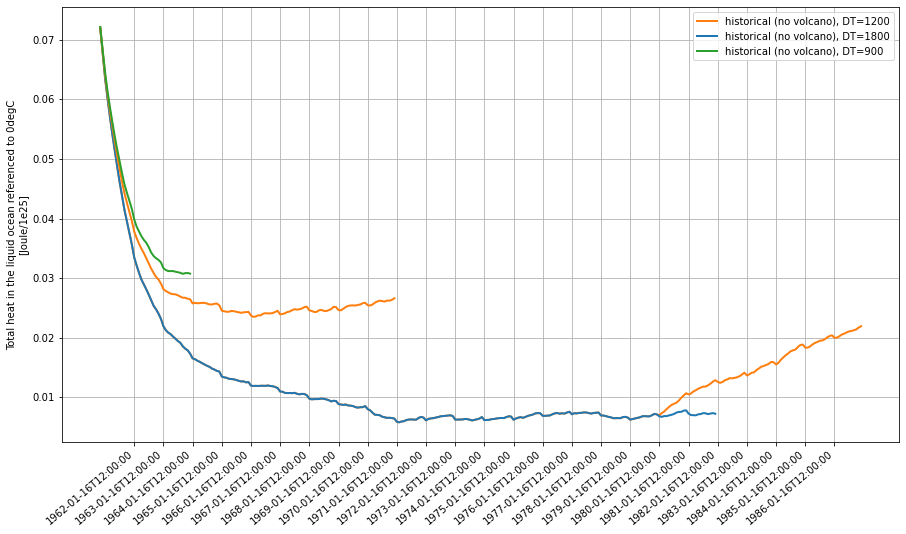

In [24]:
fig, ax0 = plt.subplots(1, 1, figsize=(15,8))

ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_branch_dt1200.time.values], 
         hist_nvol_ocean_scalar_branch_dt1200, 
         label='historical (no volcano), DT=1200', color='C1', linestyle='-', linewidth=2)
ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_branch_dt1800.time.values], 
         hist_nvol_ocean_scalar_branch_dt1800, 
         label='historical (no volcano), DT=1800', color='C0', linestyle='-', linewidth=2)
ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_dt1200.time.values], 
         hist_nvol_ocean_scalar_dt1200, 
         label='__nolabel__', color='C1', linestyle='-', linewidth=2)
ax0.plot([np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_dt900.time.values], 
         hist_nvol_ocean_scalar_dt900, 
         label='historical (no volcano), DT=900', color='C2', linestyle='-', linewidth=2)

ax0.legend()
ax0.set_ylabel(f'{variable_long_name}\n[{variable_units}]');
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in hist_nvol_ocean_scalar_branch_dt1200.time.values[2+12::12]]
ax0.set_xticks(xticks)
ax0.set_xticklabels(xticks, rotation=40, ha='right');

# CO2 forcing

In [7]:
files = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/ocean_bgc_month*.nc'))
files_branch_dt1200 = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1200/ocean_bgc_month*.nc'))
files_branch_dt1800 = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1800/ocean_bgc_month*.nc'))

In [ ]:
def read_gblannualdata(file_name):
    with open(file_name, 'r') as data:
        next(data)
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return xr.DataArray(y, dims=('year'), coords={'year': x})

In [9]:
paco2_branch_dt1200 = xr.open_mfdataset(files + files_branch_dt1200)['paco2']
paco2_branch_dt1800 = xr.open_mfdataset(files + files_branch_dt1800)['paco2']

f = read_gblannualdata(f'{forcing_path}INPUT/co2_gblannualdata')

In [15]:
def decimal_year_to_datetime(year):
    from datetime import datetime, timedelta
    year_int = int(year)
    rem = year - year_int
    base = datetime(year_int, 1, 1)
    return np.datetime64(
        base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem))

(-3653.0, 25567.0)

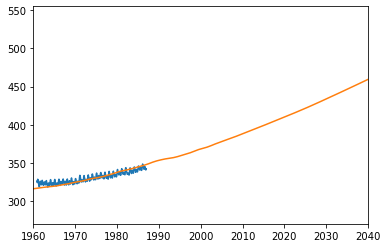

In [20]:
paco2_branch_dt1200_gbl = paco2_branch_dt1200.mean(['yt_ocean','xt_ocean']).squeeze()
paco2_branch_dt1800_gbl = paco2_branch_dt1800.mean(['yt_ocean','xt_ocean']).squeeze()

plt.plot([np.datetime64(t.strftime()) for t in paco2_branch_dt1200_gbl.time.values], 
         paco2_branch_dt1200_gbl)
plt.plot([np.datetime64(t.strftime()) for t in paco2_branch_dt1800_gbl.time.values], 
         paco2_branch_dt1800_gbl)
plt.plot([decimal_year_to_datetime(y) for y in f.year.values],
         f)
plt.xlim(np.datetime64('1960-01-01'),
         np.datetime64('2040-01-01'))

#### But remember that bgc co2 forcing is done differently, so this doesn't necessarily tell you how the other realms are going...

# aerosol forcing

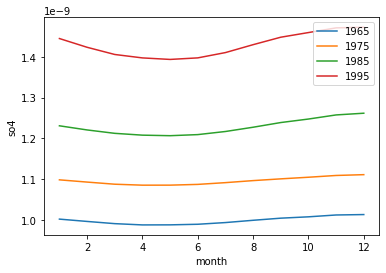

In [18]:
f = xr.open_dataset(f'{forcing_path}INPUT/aerosol.climatology.nc')
variable = 'so4'

periods = range(1965,2005,10)
for p in periods:
    var = f[variable].isel(sigma_full=0).sel(time=str(p)).mean(['lat','lon']) # Global average
    plt.plot(range(1,13), var)
plt.ylabel(variable)
plt.xlabel('month')
plt.legend(periods);

# atmos_month

In [31]:
hist_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/ZARR/atmos_hybrid_month.zarr.zip'
ctrl_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101/ZARR/atmos_hybrid_month.zarr.zip'
ctrl_nvol_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101-no_volcanos//ZARR/atmos_hybrid_month.zarr.zip'

hist_nvol_path = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/atmos_month*.nc'))
hist_nvol_path_branch_dt1200 = hist_nvol_path + sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1200/atmos_month*.nc'))
hist_nvol_path_branch_dt1800 = hist_nvol_path + sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1800/atmos_month*.nc'))
hist_nvol_path_branch_dt1800_900_1800 = hist_nvol_path + sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1800-900-1800/atmos_month*.nc'))

hist_nvol_path_dt1200 = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos-dt1200/atmos_month*.nc'))

hist_nvol_path_dt900 = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos-dt900/atmos_month*.nc'))

forcing_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-no_volcanos/mem001/'

In [33]:
hist_atmos_month = xr.open_zarr(hist_path, consolidated=True).squeeze()

hist_nvol_atmos_month_branch_dt1200 = xr.open_mfdataset(hist_nvol_path_branch_dt1200)
hist_nvol_atmos_month_branch_dt1800 = xr.open_mfdataset(hist_nvol_path_branch_dt1800)
hist_nvol_atmos_month_branch_dt1800_900_1800 = xr.open_mfdataset(hist_nvol_path_branch_dt1800_900_1800)

hist_nvol_atmos_month_dt1200 = xr.open_mfdataset(hist_nvol_path_dt1200)

hist_nvol_atmos_month_dt900 = xr.open_mfdataset(hist_nvol_path_dt900)

ctrl_atmos_month = xr.open_zarr(ctrl_path, consolidated=True).squeeze()

ctrl_nvol_atmos_month = xr.open_zarr(ctrl_nvol_path, consolidated=True).squeeze()

area = xr.open_dataset(
    '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/atmos_month_1960_11.nc')['area']

In [34]:
variable = 't_surf'
variable_long_name = ctrl_nvol_atmos_month[variable].attrs['long_name']

ctrl_atmos_month_gbl = ctrl_atmos_month[variable].weighted(area).mean(['lat','lon'])
ctrl_atmos_month_nvol_gbl = ctrl_nvol_atmos_month[variable].weighted(area).mean(['lat','lon'])
hist_atmos_month_gbl = hist_atmos_month[variable].weighted(area).mean(['lat','lon'])
hist_atmos_month_nvol_gbl_branch_dt1200 = hist_nvol_atmos_month_branch_dt1200[variable].weighted(area).mean(['lat','lon'])
hist_atmos_month_nvol_gbl_branch_dt1800 = hist_nvol_atmos_month_branch_dt1800[variable].weighted(area).mean(['lat','lon'])
hist_atmos_month_nvol_gbl_branch_dt1800_900_1800 = hist_nvol_atmos_month_branch_dt1800_900_1800[variable].weighted(area).mean(['lat','lon'])
hist_atmos_month_nvol_gbl_dt1200 = hist_nvol_atmos_month_dt1200[variable].weighted(area).mean(['lat','lon'])
hist_atmos_month_nvol_gbl_dt900 = hist_nvol_atmos_month_dt900[variable].weighted(area).mean(['lat','lon'])

clim_period = slice('1980','1999')
clim =  ctrl_atmos_month_nvol_gbl.sel(time=clim_period).groupby('time.month').mean('time')

ctrl_atmos_month_gbl_anom = ctrl_atmos_month_gbl.groupby('time.month') - clim
ctrl_atmos_month_nvol_gbl_anom = ctrl_atmos_month_nvol_gbl.groupby('time.month') - clim
hist_atmos_month_gbl_anom = hist_atmos_month_gbl.groupby('time.month') - clim
hist_atmos_month_nvol_gbl_anom_branch_dt1200 = hist_atmos_month_nvol_gbl_branch_dt1200.groupby('time.month') - clim
hist_atmos_month_nvol_gbl_anom_branch_dt1800 = hist_atmos_month_nvol_gbl_branch_dt1800.groupby('time.month') - clim
hist_atmos_month_nvol_gbl_anom_branch_dt1800_900_1800 = hist_atmos_month_nvol_gbl_branch_dt1800_900_1800.groupby('time.month') - clim
hist_atmos_month_nvol_gbl_anom_dt1200 = hist_atmos_month_nvol_gbl_dt1200.groupby('time.month') - clim
hist_atmos_month_nvol_gbl_anom_dt900 = hist_atmos_month_nvol_gbl_dt900.groupby('time.month') - clim

In [35]:
hist_gbl_vol_forcing = hist_atmos_month['vis_exopd_vl_c'].weighted(area).mean(['lat','lon'])
ctrl_gbl_vol_forcing = ctrl_atmos_month['vis_exopd_vl_c'].weighted(area).mean(['lat','lon'])

hist_gbl_qo3_forcing = hist_atmos_month['qo3_col'].weighted(area).mean(['lat','lon'])
hist_nvol_gbl_qo3_forcing_branch_dt1200 = hist_nvol_atmos_month_branch_dt1200['qo3_col'].weighted(area).mean(['lat','lon'])
hist_nvol_gbl_qo3_forcing_branch_dt1800 = hist_nvol_atmos_month_branch_dt1800['qo3_col'].weighted(area).mean(['lat','lon'])
hist_nvol_gbl_qo3_forcing_branch_dt1800_900_1800 = hist_nvol_atmos_month_branch_dt1800_900_1800['qo3_col'].weighted(area).mean(['lat','lon'])
ctrl_gbl_qo3_forcing = ctrl_atmos_month['qo3_col'].weighted(area).mean(['lat','lon'])
ctrl_nvol_gbl_qo3_forcing = ctrl_nvol_atmos_month['qo3_col'].weighted(area).mean(['lat','lon'])

# ocean_month

In [36]:
hist_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/ZARR/ocean_month.zarr.zip'
ctrl_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101/ZARR/ocean_month.zarr.zip'
ctrl_nvol_path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101-no_volcanos/ZARR/ocean_month.zarr.zip'

hist_nvol_path = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/ocean_month*.nc'))
hist_nvol_path_branch_dt1200 = hist_nvol_path + sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1200/ocean_month*.nc'))
hist_nvol_path_branch_dt1800 = hist_nvol_path + sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1800/ocean_month*.nc'))
hist_nvol_path_branch_dt1800_900_1800 = hist_nvol_path + sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/DT1800-900-1800/ocean_month*.nc'))

hist_nvol_path_dt1200 = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos-dt1200/ocean_month*.nc'))
hist_nvol_path_dt900 = sorted(glob.glob('/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos-dt900/ocean_month*.nc'))

In [37]:
hist_ocean_month = xr.open_zarr(hist_path, consolidated=True)

hist_nvol_ocean_month_branch_dt1200 = xr.open_mfdataset(hist_nvol_path_branch_dt1200)
hist_nvol_ocean_month_branch_dt1800 = xr.open_mfdataset(hist_nvol_path_branch_dt1800)
hist_nvol_ocean_month_branch_dt1800_900_1800 = xr.open_mfdataset(hist_nvol_path_branch_dt1800_900_1800)

hist_nvol_ocean_month_dt1200 = xr.open_mfdataset(hist_nvol_path_dt1200)

hist_nvol_ocean_month_dt900 = xr.open_mfdataset(hist_nvol_path_dt900)

ctrl_ocean_month = xr.open_zarr(ctrl_path, consolidated=True)

ctrl_nvol_ocean_month = xr.open_zarr(ctrl_nvol_path, consolidated=True)

area_t = xr.open_dataset(
    '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist-no_volcanos/ocean_month_1960_11.nc')['area_t']

In [38]:
def nino(sst_anom, index, wrap_lons=True, lat_name='yt_ocean', lon_name='xt_ocean'):
    """ Return nino3 index """
    def latlon_average(ds, box, wrap_lons=True, lat_name='yt_ocean', lon_name='xt_ocean'):
        def _get_latlon_region(ds, box, wrap_lons=True):
            ds = ds.assign_coords({lon_name: (ds[lon_name] + 360)  % 360})
            lon_inds = np.where(
                np.logical_and(ds[lon_name].values>=box[2], 
                               ds[lon_name].values<=box[3]))[0]
            lat_inds = np.where(
                np.logical_and(ds[lat_name].values>=box[0], 
                               ds[lat_name].values<=box[1]))[0]
            return ds.isel({lon_name: lon_inds, lat_name: lat_inds})

        return _get_latlon_region(ds, box, wrap_lons).mean(dim=[lat_name, lon_name])

    if index == '3':
        box = [-5.0, 5.0, 210.0, 270.0]
    elif index == '3.4':
        box = [-5.0, 5.0, 190.0, 240.0]
    elif index == '4':
        box = [-5.0, 5.0, 160.0, 210.0]
    else: raise InputError('Unrecognised input for index')
        
    return latlon_average(sst_anom, box, wrap_lons, lat_name, lon_name)

In [40]:
clim_period = slice('1980','1999')
clim =  ctrl_nvol_ocean_month['sst'].sel(time=clim_period).groupby('time.month').mean('time')

ctrl_sst = ctrl_ocean_month['sst'].groupby('time.month') - clim
ctrl_nvol_sst = ctrl_nvol_ocean_month['sst'].groupby('time.month') - clim
hist_sst = hist_ocean_month['sst'].groupby('time.month') - clim
hist_nvol_sst_branch_dt1200 = hist_nvol_ocean_month_branch_dt1200['sst'].groupby('time.month') - clim
hist_nvol_sst_branch_dt1800 = hist_nvol_ocean_month_branch_dt1800['sst'].groupby('time.month') - clim
hist_nvol_sst_branch_dt1800_900_1800 = hist_nvol_ocean_month_branch_dt1800_900_1800['sst'].groupby('time.month') - clim
hist_nvol_sst_dt1200 = hist_nvol_ocean_month_dt1200['sst'].groupby('time.month') - clim
hist_nvol_sst_dt900 = hist_nvol_ocean_month_dt900['sst'].groupby('time.month') - clim

ctrl_nino3 = nino(ctrl_sst, index='3')
ctrl_nvol_nino3 = nino(ctrl_nvol_sst, index='3')
hist_nino3 = nino(hist_sst, index='3')
hist_nvol_nino3_branch_dt1200 = nino(hist_nvol_sst_branch_dt1200, index='3')
hist_nvol_nino3_branch_dt1800 = nino(hist_nvol_sst_branch_dt1800, index='3')
hist_nvol_nino3_branch_dt1800_900_1800 = nino(hist_nvol_sst_branch_dt1800_900_1800, index='3')
hist_nvol_nino3_dt1200 = nino(hist_nvol_sst_dt1200, index='3')
hist_nvol_nino3_dt900 = nino(hist_nvol_sst_dt900, index='3')

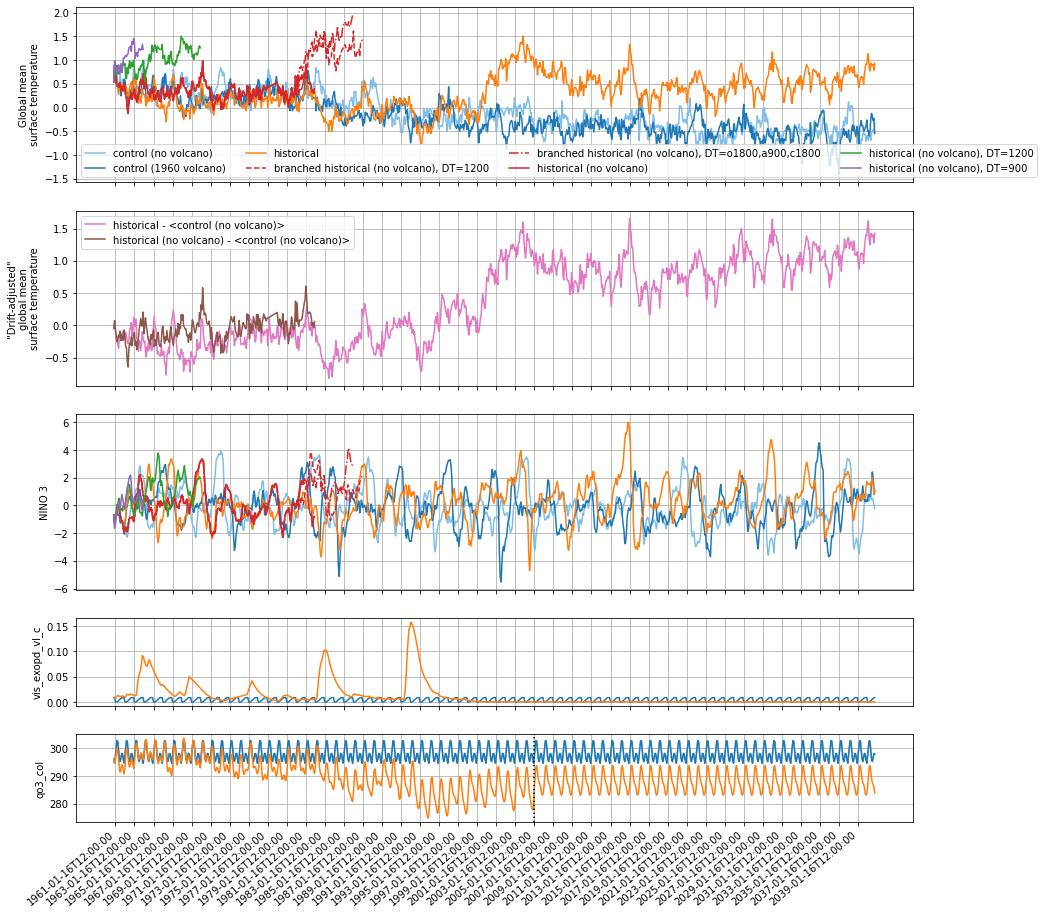

In [41]:
from matplotlib.ticker import FormatStrFormatter

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, 
                                              gridspec_kw={'height_ratios': [2, 2, 2, 1, 1]}, 
                                              figsize=(15,15))

ax0.plot([np.datetime64(t.strftime()) for t in ctrl_atmos_month_nvol_gbl_anom.time.values], 
         ctrl_atmos_month_nvol_gbl_anom, label='control (no volcano)', color=lighten('C0'), linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in ctrl_atmos_month_gbl_anom.time.values], 
         ctrl_atmos_month_gbl_anom, label='control (1960 volcano)', color='C0', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_atmos_month_gbl_anom.time.values], 
         hist_atmos_month_gbl_anom, label='historical', color='C1')
ax0.plot([np.datetime64(t.strftime()) for t in hist_atmos_month_nvol_gbl_anom_branch_dt1200.time.values], 
         hist_atmos_month_nvol_gbl_anom_branch_dt1200, label='branched historical (no volcano), DT=1200', color='C3', linestyle='--')
ax0.plot([np.datetime64(t.strftime()) for t in hist_atmos_month_nvol_gbl_anom_branch_dt1800_900_1800.time.values], 
         hist_atmos_month_nvol_gbl_anom_branch_dt1800_900_1800, label='branched historical (no volcano), DT=o1800,a900,c1800', color='C3', linestyle='-.')
ax0.plot([np.datetime64(t.strftime()) for t in hist_atmos_month_nvol_gbl_anom_branch_dt1800.time.values], 
         hist_atmos_month_nvol_gbl_anom_branch_dt1800, label='historical (no volcano)', color='C3', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_atmos_month_nvol_gbl_anom_dt1200.time.values], 
         hist_atmos_month_nvol_gbl_anom_dt1200, label='historical (no volcano), DT=1200', color='C2', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_atmos_month_nvol_gbl_anom_dt900.time.values], 
         hist_atmos_month_nvol_gbl_anom_dt900, label='historical (no volcano), DT=900', color='C4', linestyle='-')


ax0.legend(ncol=4)
ax0.set_ylabel(f'Global mean\n{variable_long_name}'); 
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in ctrl_atmos_month_nvol_gbl_anom.time.values[2::24]]
ax0.set_xticks(xticks)
ax0.set_xticklabels([])
xlims = ax0.get_xlim()

ctrl_atmos_month_nvol_gbl_anom_smooth = ctrl_atmos_month_nvol_gbl_anom.rolling(time=72, min_periods=1).mean('time')
ctrl_atmos_month_gbl_anom_smooth = ctrl_atmos_month_gbl_anom.rolling(time=72, min_periods=1).mean('time')
ax1.plot([np.datetime64(t.strftime()) for t in (hist_atmos_month_gbl_anom-ctrl_atmos_month_nvol_gbl_anom_smooth).time.values], 
         hist_atmos_month_gbl_anom-ctrl_atmos_month_nvol_gbl_anom_smooth, 
         label='historical - <control (no volcano)>', color='C6')
ax1.plot([np.datetime64(t.strftime()) for t in (hist_atmos_month_nvol_gbl_anom_branch_dt1800-ctrl_atmos_month_nvol_gbl_anom_smooth).time.values], 
         hist_atmos_month_nvol_gbl_anom_branch_dt1800-ctrl_atmos_month_nvol_gbl_anom_smooth, 
         label='historical (no volcano) - <control (no volcano)>', color='C5')
ax1.legend()
ax1.set_ylabel(f'"Drift-adjusted"\nglobal mean\n{variable_long_name}');
ax1.grid()
ax1.set_xticks(xticks)
ax1.set_xticklabels([])
ax1.set_xlim(xlims);

ax2.plot([np.datetime64(t.strftime()) for t in ctrl_nvol_nino3.time.values], 
         ctrl_nvol_nino3, label='control (no volcano)', color=lighten('C0'), linestyle='-')
ax2.plot([np.datetime64(t.strftime()) for t in ctrl_nino3.time.values], 
         ctrl_nino3, label='control (1960 volcano)', color='C0', linestyle='-')
ax2.plot([np.datetime64(t.strftime()) for t in hist_nino3.time.values], 
         hist_nino3, label='historical', color='C1')
ax2.plot([np.datetime64(t.strftime()) for t in hist_nvol_nino3_branch_dt1200.time.values], 
         hist_nvol_nino3_branch_dt1200, label='branched historical (no volcano), DT=1200', color='C3', linestyle='--')
ax2.plot([np.datetime64(t.strftime()) for t in hist_nvol_nino3_branch_dt1800_900_1800.time.values], 
         hist_nvol_nino3_branch_dt1800_900_1800, label='branched historical (no volcano), DT=o1800,a900,c1800', color='C3', linestyle='-.')
ax2.plot([np.datetime64(t.strftime()) for t in hist_nvol_nino3_branch_dt1800.time.values], 
         hist_nvol_nino3_branch_dt1800, label='historical (no volcano)', color='C3', linestyle='-')
ax2.plot([np.datetime64(t.strftime()) for t in hist_nvol_nino3_dt1200.time.values], 
         hist_nvol_nino3_dt1200, label='historical (no volcano), DT=1200', color='C2', linestyle='-')
ax2.plot([np.datetime64(t.strftime()) for t in hist_nvol_nino3_dt900.time.values], 
        hist_nvol_nino3_dt900, label='historical (no volcano), DT=1200', color='C4', linestyle='-')
# ax2.plot([np.datetime64(t.strftime()) for t in hist_nino34.time.values], 
#          hist_nino34, label='historical Nino 3.4', color='C4')
# ax2.plot([np.datetime64(t.strftime()) for t in hist_nino4.time.values], 
#          hist_nino4, label='historical Nino 4', color='C5')

# ax2.legend()
ax2.set_ylabel('NINO 3');
ax2.grid()
ax2.set_xticks(xticks)
ax2.set_xticklabels([])
ax2.set_xlim(xlims);

# ====================================================
# Forcing
ax3.plot([np.datetime64(t.strftime()) for t in ctrl_gbl_vol_forcing.time.values],
         ctrl_gbl_vol_forcing, 
         color='C0', label='control (1960 volcano)')
ax3.plot([np.datetime64(t.strftime()) for t in hist_gbl_vol_forcing.time.values],
         hist_gbl_vol_forcing, 
         color='C1',label='historical')
# ax3.legend()
ax3.grid()
ax3.set_xticks(xticks)
ax3.set_xticklabels([]);
ax3.set_ylabel('vis_exopd_vl_c');
ax3.set_xlim(xlims);

# ctrl_nvol_gbl_qo3_forcing.plot(ax=ax1, color=lighten('C0'))
ax4.plot([np.datetime64(t.strftime()) for t in ctrl_nvol_gbl_qo3_forcing.time.values],
         ctrl_nvol_gbl_qo3_forcing, color=lighten('C0'), label='control (no volcano)')
ax4.plot([np.datetime64(t.strftime()) for t in ctrl_gbl_qo3_forcing.time.values],
         ctrl_gbl_qo3_forcing, color='C0', label='control (1960 volcano)')
ax4.plot([np.datetime64(t.strftime()) for t in hist_gbl_qo3_forcing.time.values],
         hist_gbl_qo3_forcing, color='C1',label='historical')

ylims = ax4.get_ylim()
ax4.plot([np.datetime64('2005-01-01'), np.datetime64('2005-01-01')], 
         ylims, 'k:')
ax4.grid()
ax4.set_ylim(ylims)
ax4.set_xticks(xticks)
ax4.set_xticklabels(xticks, rotation=40, ha='right');
ax4.set_ylabel('qo3_col');
ax4.set_xlim(xlims);

# How do maps evolve through time

In [69]:
import matplotlib
from xmovie import Movie
import matplotlib.dates as mdates

fs = 6
font = {'weight' : 'normal',
        'size'   : fs}
matplotlib.rc('font', **font)

def weighted_mean(da):
    if ('lat' in da.dims) & ('lon' in da.dims):
        return da.weighted(area).mean(['lat','lon'])
    elif ('yt_ocean' in da.dims) & ('xt_ocean' in da.dims):
        return da.weighted(area_t).mean(['yt_ocean','xt_ocean'])
    else:
        raise InputError("I don't know how to dop the weighted mean")
    
def plot_maps(ds, fig, tt, framedim="time"):
    (ax1, ax2, ax3, ax4) = fig.subplots(ncols=4, 
                              gridspec_kw={'width_ratios': [1, 1, 1.25, 0.8]})
    
    a = list(ds.data_vars)[0]
    b = list(ds.data_vars)[1]
    
    vmin = min(ds[a].min().values, ds[b].min().values)
    vmax = max(ds[a].max().values, ds[b].max().values)
    dmin = (ds[a]-ds[b]).min().values
    dmax = (ds[a]-ds[b]).max().values
    d = 0.7*max(-dmin, dmax)
    ds[a].isel({framedim:tt}).plot(ax=ax1, vmin=vmin, vmax=vmax, cmap='magma', add_colorbar=False)
    ds[b].isel({framedim:tt}).plot(ax=ax2, vmin=vmin, vmax=vmax, cmap='magma', add_colorbar=False)
    (ds[a]-ds[b]).isel({framedim:tt}).plot(ax=ax3, vmin=-d, vmax=d, cmap='Spectral_r')
    
    ax1.set_title(a)
    ax2.set_title(b)
    ax3.set_title('Difference')
    
    ax2.set_yticklabels([])
    ax2.set_ylabel('')
    ax3.set_yticklabels([])
    ax3.set_ylabel('')
    
    a_gbl = weighted_mean(ds[a])
    b_gbl = weighted_mean(ds[b])
    ax4.plot([np.datetime64(t.strftime()) for t in a_gbl.time.values], 
             a_gbl, label=a, color='C0', linestyle='-')
    ax4.plot([np.datetime64(t.strftime()) for t in b_gbl.time.values], 
             b_gbl, label=b, color='C1', linestyle='-')
    
    xticks = [np.datetime64(t.strftime()) for t in a_gbl.time.values]
    ax4.set_xticks(xticks[::4])
    ax4.set_xticklabels(xticks[::4], rotation=90, ha='center');
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ylims = ax4.get_ylim()
    ax4.plot([np.datetime64(ds.isel({framedim:tt}).time.item().strftime()),
              np.datetime64(ds.isel({framedim:tt}).time.item().strftime())],
             ylims, color='k', linewidth=0.75, zorder=0)
    ax4.legend(loc='upper left', fontsize=fs-2)
    ax4.set_ylim(ylims)
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    
    fig.suptitle(f'{ds.isel({framedim:tt}).time.values}')
    fig.subplots_adjust(wspace=0.02, hspace=0.1)
    plt.tight_layout()

In [70]:
plt.rcParams['animation.ffmpeg_path'] = '/g/data/v14/ds0092/software/miniconda3/envs/pangeo-xmovie/bin/ffmpeg'

period = slice('1960','1965')
# period = slice('1980','1981')

# a = hist_nvol_atmos_month_branch_dt1200['t_surf'].sel(time=period).compute().rename('t_surf, DT=1200s')
# b = hist_nvol_atmos_month_branch_dt1800['t_surf'].sel(time=period).compute().rename('t_surf, DT=1800s')

# a = hist_nvol_ocean_month_branch_dt1200['sst'].sel(time=period).compute().rename('sst, DT=1200s')
# b = hist_nvol_ocean_month_branch_dt1800['sst'].sel(time=period).compute().rename('sst, DT=1800s')

a = hist_nvol_ocean_month_dt1200['sst'].sel(time=period).compute().rename('sst, DT=1200s')
b = hist_nvol_ocean_month_branch_dt1800['sst'].sel(time=period).compute().rename('sst, DT=1800s')

mov_custom = Movie(
    xr.merge([a,b]), plot_maps, 
    pixelwidth=2*1920,
    pixelheight=2/3*1080,
    input_check=False, dpi=400)
mov_custom.save('movie.mp4', overwrite_existing=True, framerate=2)

Movie created at movie.mp4


# atmos_daily

In [80]:
hist_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist/'
ctrl_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/ctrl/'
ctrl_nvol_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/ctrl-no_volcanos/'

In [81]:
drop = ['bk', 'pk', 'average_T1', 'average_T2', 'average_DT', 'time_bounds']

hist_files = sorted(glob.glob(f'{hist_path}atmos_daily_*.nc'))
hist_atmos_daily = xr.open_mfdataset(hist_files).drop(drop)

ctrl_files = sorted(glob.glob(f'{ctrl_path}atmos_daily_*.nc'))
ctrl_atmos_daily = xr.open_mfdataset(ctrl_files).drop(drop)

ctrl_nvol_files = sorted(glob.glob(f'{ctrl_nvol_path}atmos_daily_*.nc'))
ctrl_nvol_atmos_daily = xr.open_mfdataset(ctrl_nvol_files).drop(drop)

/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/v14/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  ret

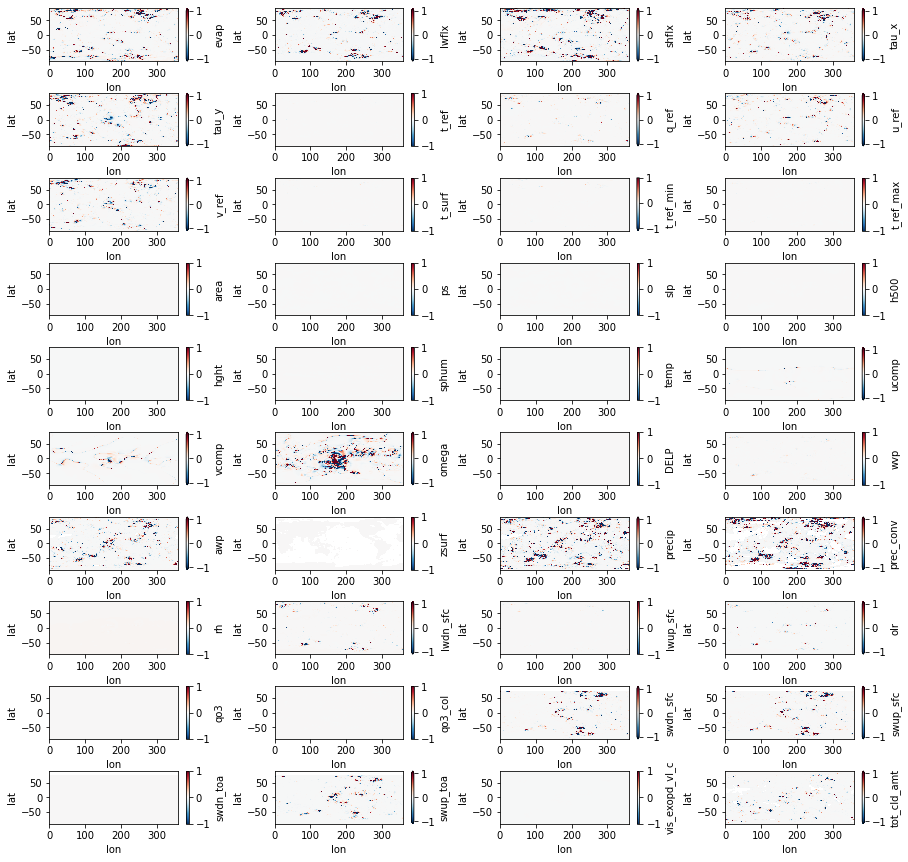

In [104]:
ncols = 4
nrows = 10

fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))

a = ctrl_atmos_daily.isel(pfull=0, phalf=0, time=0)
b = hist_atmos_daily.isel(pfull=0, phalf=0, time=0)

variables = ctrl_atmos_daily.data_vars
for v, ax in zip(variables, axs.flatten()):
    (100 * (b[v] - a[v]) / a[v]).plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')
    ax.set_title('')
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    
plt.subplots_adjust(wspace=0.4, hspace=0.6)